## Facial Keypoint Analysis - A Tutorial Code
Here I will use a Convolutional Neural Net to indetify the facial keypoints.
For each image we indetify 15 facial keypoints, e.g., the location of the eyes and the nose.

The training and test data come from kaggle-facial-keypoint-detection

In [9]:
from __future__ import print_function

import sys
import os
import time

import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

import lasagne

from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from types import *
from nolearn.lasagne import NeuralNet

%matplotlib inline

# Import Data and convert to the correct format

In [10]:
FTRAIN = '~/Documents/Python_test_deeplearning/kaggle_data/training.csv'
FTEST = '~/Documents/Python_test_deeplearning/kaggle_data/test.csv'

In [11]:
def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns How do we do validation then?
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

Here is the 2d loader. This makes X a stack of images each 96X96

In [12]:
def load2d(test=False, cols=None):
    X, y = load(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

### Load Data

In [20]:
X_train, y_train = load2d()
X_test, y_test = load2d(test=True)
# Create a dataset dictionary for convenience
dataset = {
    'train': {'X': X_train, 'y': y_train},
    'test': {'X':X_test,'y': y_test}}

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [14]:
print("X shape (train) == {}; X min == {:.3f}; X max == {:.3f}".format(
    dataset['train']['X'].shape, dataset['train']['X'].min(), dataset['train']['X'].max()))
print("y shape (train) == {}; y min == {:.3f}; y max == {:.3f}".format(
    dataset['train']['y'].shape, dataset['train']['y'].min(), dataset['train']['y'].max()))
print("X shape (test) == {}; X min == {:.3f}; X max == {:.3f}".format(
    dataset['test']['X'].shape, dataset['test']['X'].min(), dataset['test']['X'].max()))

X shape (train) == (2140, 1, 96, 96); X min == 0.000; X max == 1.000
y shape (train) == (2140, 30); y min == -0.920; y max == 0.996
X shape (test) == (1783, 1, 96, 96); X min == 0.000; X max == 1.000


### Plot Example

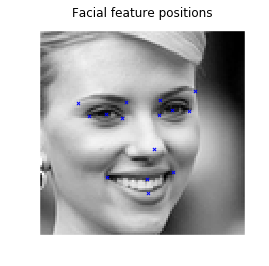

In [8]:
plt.imshow(dataset['train']['X'][12][0], interpolation='nearest', cmap=plt.cm.gray)
plt.scatter(dataset['train']['y'][12][0::2] * 48 + 48, dataset['train']['y'][12][1::2] * 48 + 48, marker='x', s=10)
plt.title("Facial feature positions")
plt.gca().set_axis_off()

## Build A Neural Net with No Learn
We will use nolearns NeuralNet function which has the advantage of automatic history functions
Lets use 3 convolutional layers and 2 hidden layers with drop out
1. Convolutional layer 1 
> has 32 filters and 3x3 field.
This layer is pooled using max pooling with a pool size of 2
2. Convolutional layer 2 has 64 filters and a 2x2 field
> has 64 filters and a 2x2 field
this layer is pooled using max pooling with a pool size of 2
3. Convolutional layer 2 
> has 128 filters and a 2x2 field 
this layer is pooled using max pooling with a pool size of 2
4. Hidden layer 1
> has 500 units and a dropout of 70%
5. Hidden layer 2
> has 500 units and a dropout of 20%
6. Output layer 
> has 30 elements, one for each of the facial keypoint

In [37]:
input_size = dataset['train']['X'][0].shape
net = NeuralNet(
    layers=[
        ('input', lasagne.layers.InputLayer),
        ('conv1', lasagne.layers.Conv2DLayer),
        ('pool1', lasagne.layers.MaxPool2DLayer),
        ('conv2', lasagne.layers.Conv2DLayer),
        ('pool2', lasagne.layers.MaxPool2DLayer),
        ('conv3', lasagne.layers.Conv2DLayer),
        ('pool3', lasagne.layers.MaxPool2DLayer),
        ('hidden4', lasagne.layers.DenseLayer),
        ('hidden5', lasagne.layers.DenseLayer),
        ('output', lasagne.layers.DenseLayer),
        ],
    input_shape=(None, input_size[0], input_size[1], input_size[2]),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,
    
    update=lasagne.updates.nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,
    max_epochs=2,
    verbose=1,
    )

## Training using NuralNet function

In [38]:
net.fit(dataset['train']['X'],dataset['train']['y'])

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  ------
      1       0.12904       0.08245      1.56519  64.37s
      2       0.03456       0.01164      2.96811  74.43s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x1196b23d0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x1196b2290>,
     conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=2, more_params={},
     objective=<function objective at 0x1196b37d0>,
     objective_loss_func

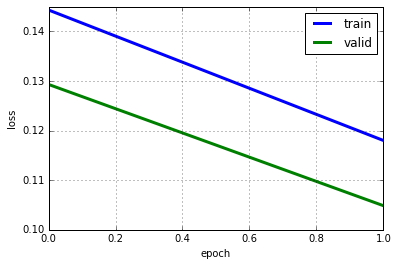

In [35]:
train_loss = np.array([i["train_loss"] for i in net.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")